# constrActive optimization

In [11]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
from eden.util import configure_logging
import logging
logger = logging.getLogger()
configure_logging(logger,verbosity=1)
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from toolz import curry, pipe
from eden_chem.io.pubchem import download
from eden_chem.io.rdkitutils import sdf_to_nx

download_active = curry(download)(active=True)
download_inactive = curry(download)(active=False)

def get_pos_graphs(assay_id): return pipe(assay_id, download_active, sdf_to_nx, list)
def get_neg_graphs(assay_id): return pipe(assay_id, download_inactive, sdf_to_nx, list)

# Set up input graphs

In [13]:
from IPython.core.display import display
from eden_chem.display.rdkitutils import nx_to_image

def draw_mols(graphs, num=15, n_graphs_per_line=7):
    titles = [graph.graph.get('id',i) for i, graph in enumerate(graphs)]
    img = nx_to_image(graphs[:num], n_graphs_per_line=n_graphs_per_line, titles=titles)
    display(img)


def draw_rdkit(ideal_graphs, top_graphs, num=15, n_graphs_per_line=7):
    print('Ideal graphs: %d' % len(ideal_graphs))
    draw_mols(ideal_graphs, num=num, n_graphs_per_line=n_graphs_per_line)

    print('Top k graphs: %d' % len(top_graphs))
    draw_mols(top_graphs, num=num, n_graphs_per_line=n_graphs_per_line)

In [14]:
from eden.display import map_labels_to_colors
from eden.display import draw_graph_set       

class GraphDrawer(object):
    """GD."""

    def __init__(self, n_graphs_per_line=5, num_lines=4, size=8):
        """init."""
        self.n_graphs_per_line = n_graphs_per_line
        self.num_lines = num_lines
        self.size = size

    def fit(self, graphs):
        """fit."""
        label_colors = map_labels_to_colors(graphs)
        self.draw_params = dict(
            n_graphs_per_line=self.n_graphs_per_line, 
            size=self.size, 
            colormap='Paired', 
            vertex_color='_labels_', 
            vertex_color_dict=label_colors, 
            vertex_alpha=0.5, 
            edge_alpha=0.2)
        return self

    def draw(self, orig_graphs):
        graphs = orig_graphs[:self.num_lines*self.n_graphs_per_line]
        draw_graph_set(graphs, **self.draw_params)

# Experiment

In [15]:
from constrActive.utils import pre_process, _random_sample

def make_data(assay_id, max_size=20):
    # extract pos and neg graphs
    all_pos_graphs, all_neg_graphs = get_pos_graphs(assay_id), get_neg_graphs(assay_id)

    # remove too large and too small graphs and outliers
    args=dict(initial_max_size=4000, fraction_to_remove=.2, n_neighbors_for_outliers=3, remove_similar=True, max_size=max_size)
    logging.debug('\nPositive graphs')
    pos_graphs = pre_process(all_pos_graphs, **args)
    logging.debug('\nTest positive graphs')
    ts_pos_graphs = _random_sample([g for g in all_pos_graphs if g not in pos_graphs], len(pos_graphs)*2)

    logging.debug('\nNegative graphs')
    neg_graphs = pre_process(all_neg_graphs, **args)
    logging.debug('\nTest negative graphs')
    ts_neg_graphs = _random_sample([g for g in all_neg_graphs if g not in neg_graphs], len(neg_graphs)*2)
    logger.debug('-'*80)
    
    return pos_graphs, neg_graphs, ts_pos_graphs, ts_neg_graphs

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Perceptron
from constrActive.ideal_graph_estimator import IdealGraphEstimator

def make_ideal_graph_estimator(pos_graphs, neg_graphs, ts_pos_graphs, ts_neg_graphs, 
                               n_neighbors=50, n_landmarks=7, max_num_solutions=100):
    # estimate eprformance of EDeN classifier model
    est = EdenEstimator(r=3, d=6, penalty='perceptron', nbits=16, normalization=True, inner_normalization=True)
    ts_y = [1] * len(ts_pos_graphs) + [-1] * len(ts_neg_graphs)
    tr_y = [1] * len(pos_graphs) + [-1] * len(neg_graphs)
    tr_size = len(tr_y)
    scores = est.cross_val_score(pos_graphs+neg_graphs, tr_y, scoring='roc_auc', cv=10)
    tr_roc, tr_roc_std = np.mean(scores),np.std(scores)
    logger.info("CV   AUC ROC: %0.3f (+/- %0.3f) [%0.3f:%0.3f]" % (tr_roc, tr_roc_std, tr_roc-tr_roc_std, tr_roc+tr_roc_std))
    est.fit(pos_graphs+neg_graphs, tr_y)
    ts_preds = est.decision_function(ts_pos_graphs+ts_neg_graphs)
    ts_roc = roc_auc_score(ts_y, ts_preds)
    logger.info('Test AUC ROC: %.3f' % ts_roc)
    
    # make IGE 
    logger.info('-'*80)
    clf = Perceptron(n_iter=500) 
    ige = IdealGraphEstimator(  
        n_neighbors=n_neighbors,
        n_landmarks=n_landmarks,
        max_num_solutions=max_num_solutions)
    ige.fit(pos_graphs, neg_graphs)
    tr_xtr = ige.transform(pos_graphs+neg_graphs)
    n_graphs, n_feat = len(ige.ideal_graphs_), tr_xtr.shape[1]
    logger.info('Using %d selected constructs for %d features'%(n_graphs, n_feat))
    scores = cross_val_score(clf, tr_xtr, tr_y, cv=10, scoring='roc_auc')
    tr_ige_roc, tr_ige_roc_std = np.mean(scores),np.std(scores)
    logger.info('Train CV AUC ROC: %.3f +- %.3f [%0.3f:%0.3f]'%(tr_ige_roc, tr_ige_roc_std,tr_ige_roc-tr_ige_roc_std, tr_ige_roc+tr_ige_roc_std))
    clf.fit(tr_xtr, tr_y)
    ts_xtr = ige.transform(ts_pos_graphs+ts_neg_graphs)
    ts_ige_preds = clf.decision_function(ts_xtr)
    ts_ige_roc = roc_auc_score(ts_y, ts_ige_preds)
    logger.info('Test     AUC ROC: %.3f' % ts_ige_roc)
    return ige, est, (tr_roc, tr_roc_std, ts_roc, tr_ige_roc, tr_ige_roc_std, ts_ige_roc, n_graphs, n_feat, tr_size)

In [17]:
from eden.ml.estimator import EdenEstimator
from sklearn.metrics import roc_auc_score

def make_experiment(assay_id, max_size=20, n_neighbors=2, n_landmarks=50, max_num_solutions=10):
    def sort_graphs(orig_graphs, est):
        preds = est.decision_function(orig_graphs)
        graphs=[]
        for pred, graph in sorted(zip(preds, orig_graphs), reverse=True):
            graph.graph['id']='%.3f'%pred
            graphs.append(graph)
        return graphs

    pos_graphs, neg_graphs, ts_pos_graphs, ts_neg_graphs = make_data(assay_id, max_size=max_size)
    ige, est, rocs = make_ideal_graph_estimator(pos_graphs, neg_graphs, ts_pos_graphs, ts_neg_graphs, 
                                                n_neighbors=n_neighbors, n_landmarks=n_landmarks, max_num_solutions=max_num_solutions)
    ideal_graphs = sort_graphs(ige.ideal_graphs_, est)
    top_graphs = sort_graphs(pos_graphs, est)
    return rocs, ideal_graphs, top_graphs

def make_experiments(assay_ids, args):
    rocs_list = []
    for assay_id in assay_ids:
        print('\n\n')
        print('='*80)
        print('Exp: %s' % assay_id)
        print('_'*80)
        rocs, ideal_graphs, top_graphs = make_experiment(assay_id, **args)
        draw_rdkit(ideal_graphs, top_graphs, num=7*4, n_graphs_per_line=7)
        rocs_list.append(list(rocs))
    return rocs_list

In [18]:
import numpy as np
import pylab as plt
import time

def _extract_std(R):
    x = R[:,2]
    y1 = R[:,2]-R[:,1]
    y2 = R[:,2]+R[:,1] 
    xy12 = np.hstack([x.reshape(-1,1),y1.reshape(-1,1),y2.reshape(-1,1)])
    ids = np.argsort(x)
    xy12 = xy12[ids]
    x = np.array(xy12[:,0])
    y1 = np.array(xy12[:,1])
    y2 = np.array(xy12[:,2])
    return x, y1, y2

def plot(rocs_list, fname_prefix=''):
    def plot_(xx,yy,xlabel,ylabel,i, display_std=True):
        plt.subplot(1, n_graphs_per_line, i + 1)
        if display_std:
            plt.fill_between(x,y1,y2, color='b', alpha=0.2)
        plt.scatter(xx,yy)
        plt.plot([0.5, 1], [0.5, 1], color='gray', lw=1, linestyle='--')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.grid(linestyle=":")


    R = np.array(rocs_list)
    x, y1, y2 = _extract_std(R)

    plot_size=5
    n_graphs_per_line=2
    plt.figure(figsize=(plot_size*n_graphs_per_line, plot_size))
        
    plot_(R[:,2],R[:,0],'ROC Test EDeN','ROC CV Train EDeN',0)
    plot_(R[:,2],R[:,5],'ROC Test EDeN','ROC Test IGE',1)
    
    timestamp = time.strftime('%Y_%m_%d_%H_%M_%S')
    plt.savefig('%s_roc_plots_%s.pdf'%(fname_prefix, timestamp),
                bbox_inches='tight',transparent=True,pad_inches=0)
    plt.show()

---

In [19]:
#assay_ids=['492992','463230','588350','651610','624466','492952','463213','119','1224857','2326']
assay_ids=['492992','463230','588350','651610','624466','492952','463213']

args = dict(max_size=1000, n_neighbors=100, n_landmarks=7, max_num_solutions=100)




Exp: 492992
________________________________________________________________________________
CV   AUC ROC: 0.786 (+/- 0.067) [0.719:0.853]
Test AUC ROC: 0.826
--------------------------------------------------------------------------------
Using 64 selected constructs for 204 features
Train CV AUC ROC: 0.709 +- 0.060 [0.649:0.769]
Test     AUC ROC: 0.723
Ideal graphs: 64


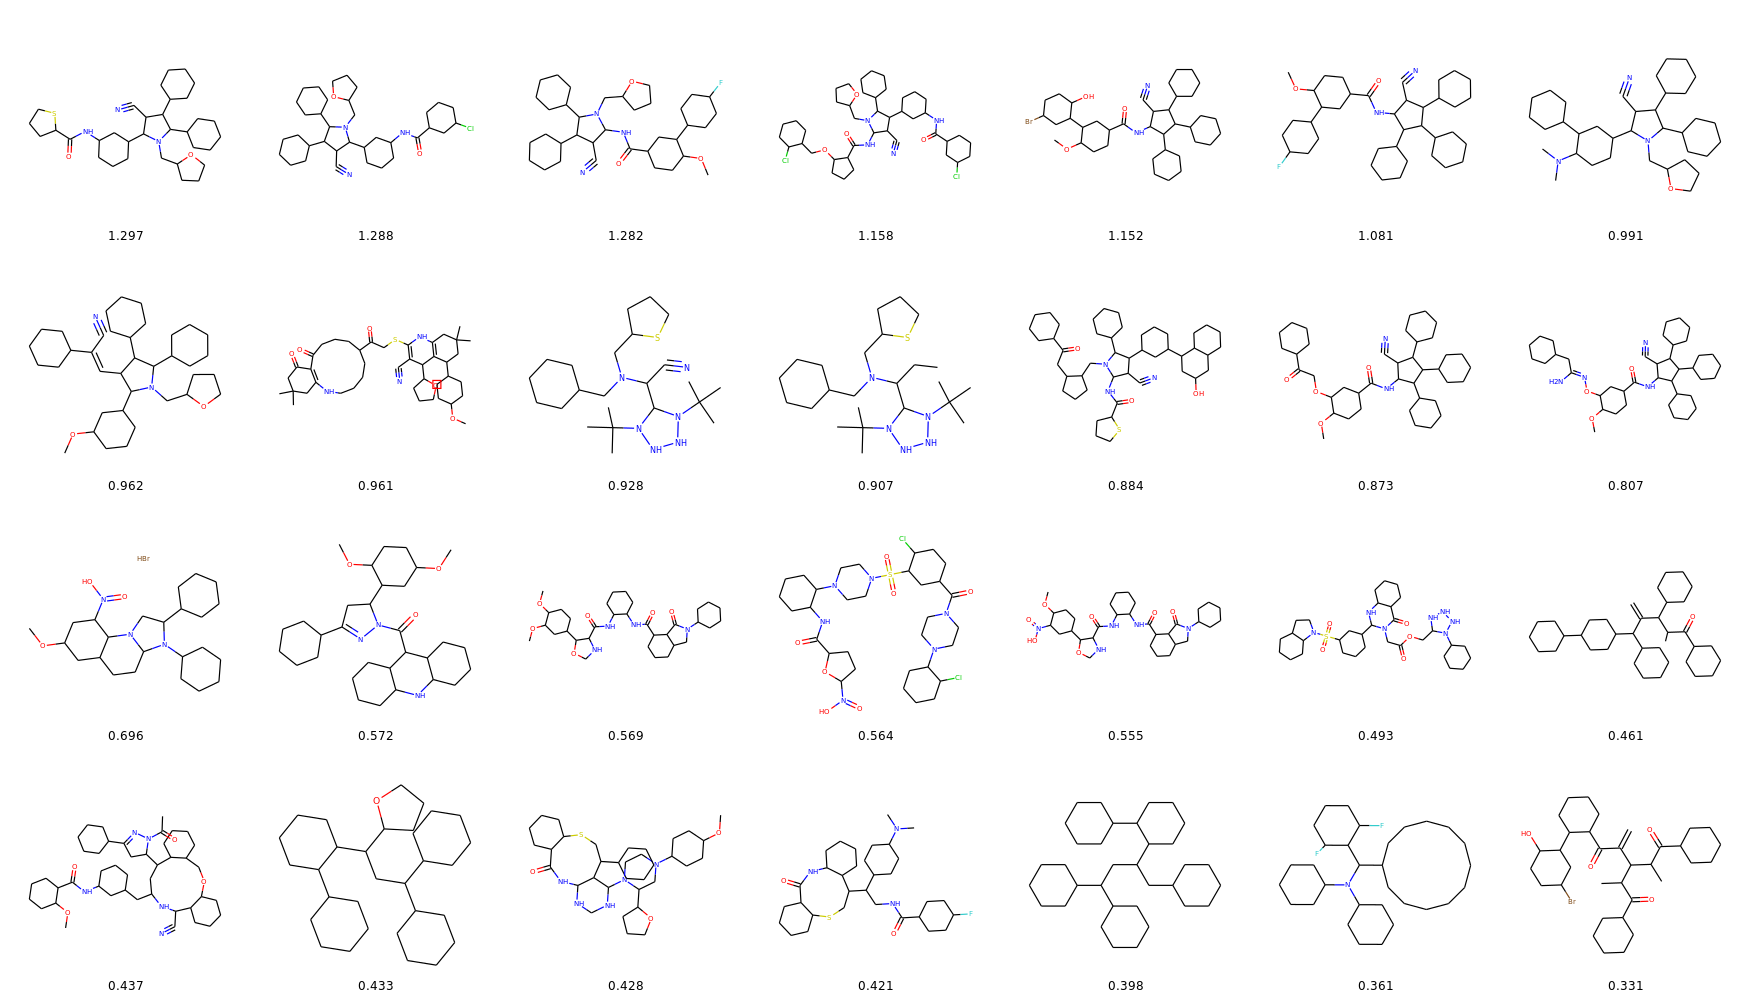

Top k graphs: 602


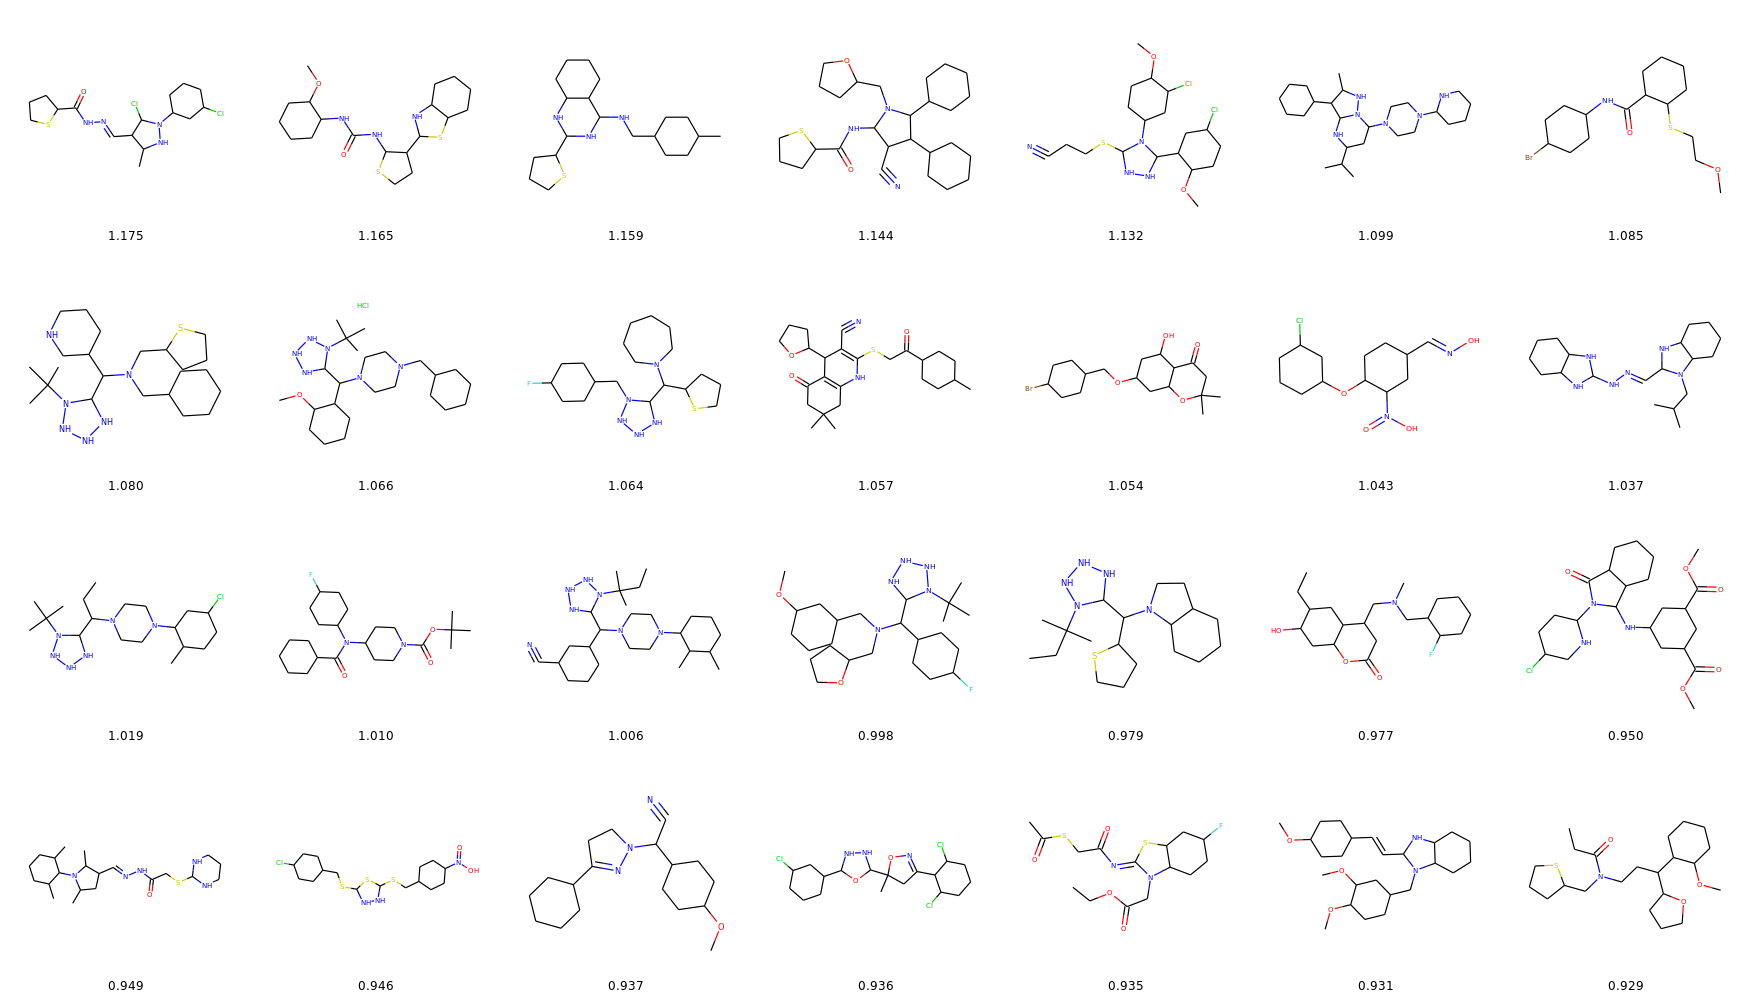




Exp: 463230
________________________________________________________________________________
CV   AUC ROC: 0.740 (+/- 0.098) [0.642:0.838]
Test AUC ROC: 0.784
--------------------------------------------------------------------------------
Using 74 selected constructs for 273 features
Train CV AUC ROC: 0.760 +- 0.059 [0.701:0.819]
Test     AUC ROC: 0.726
Ideal graphs: 74


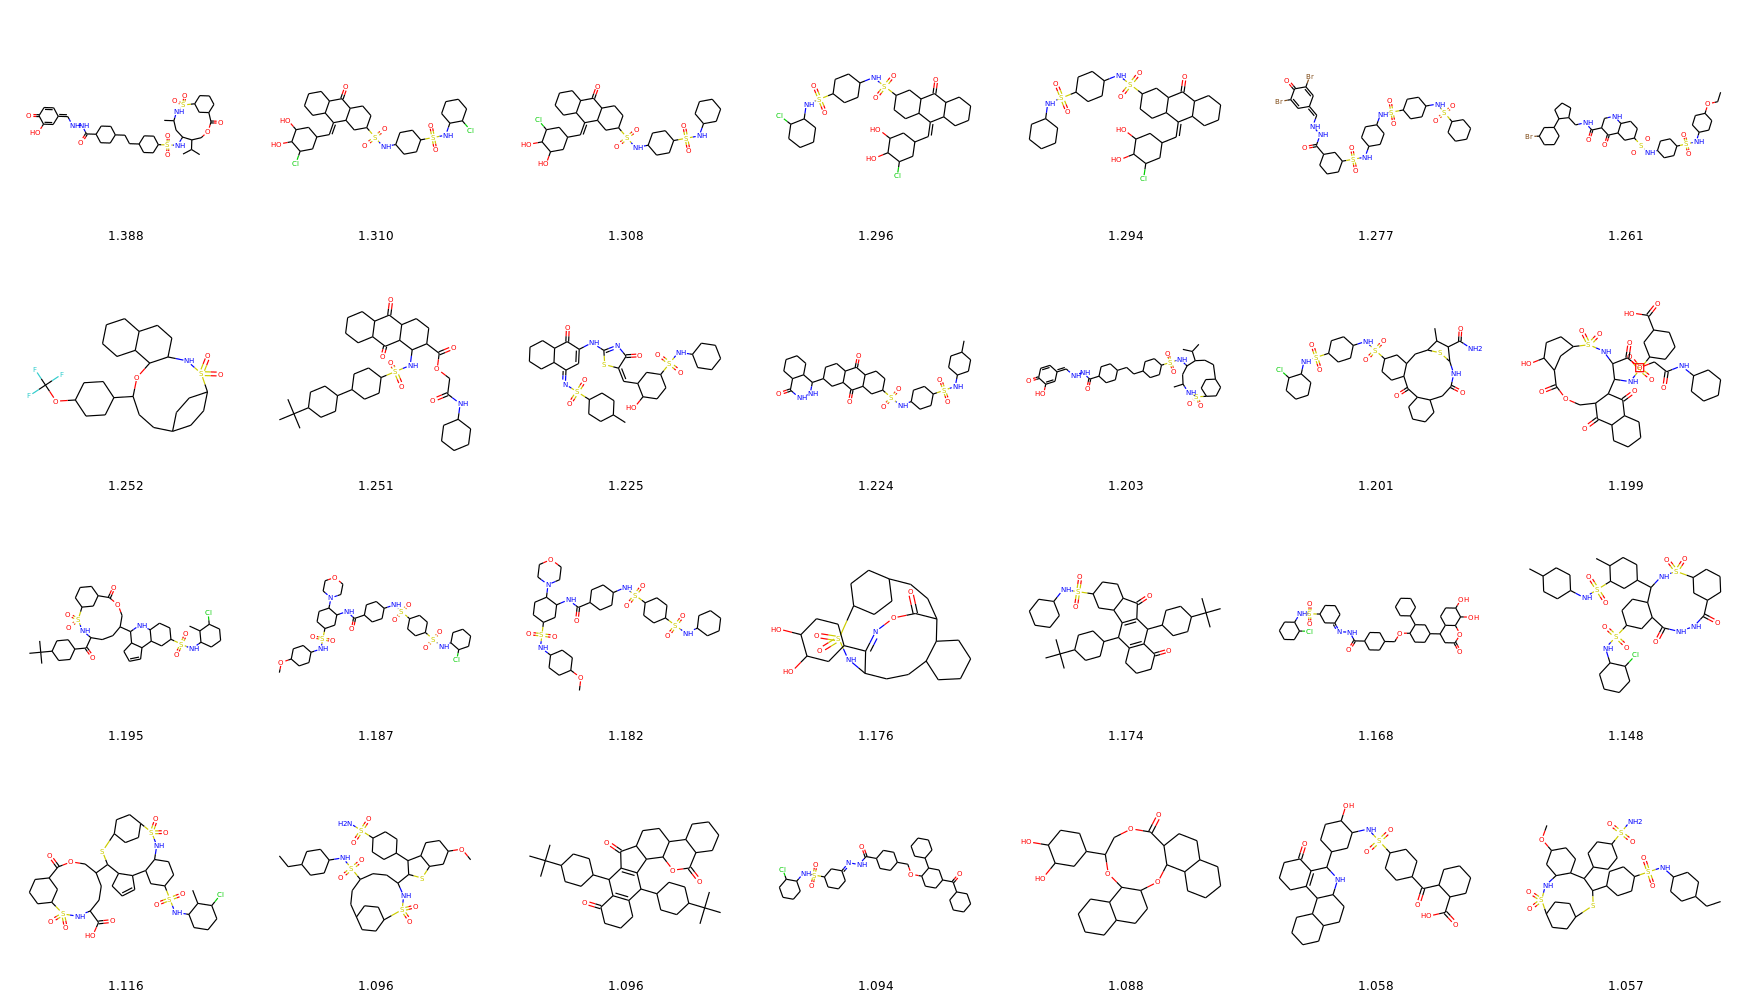

Top k graphs: 500


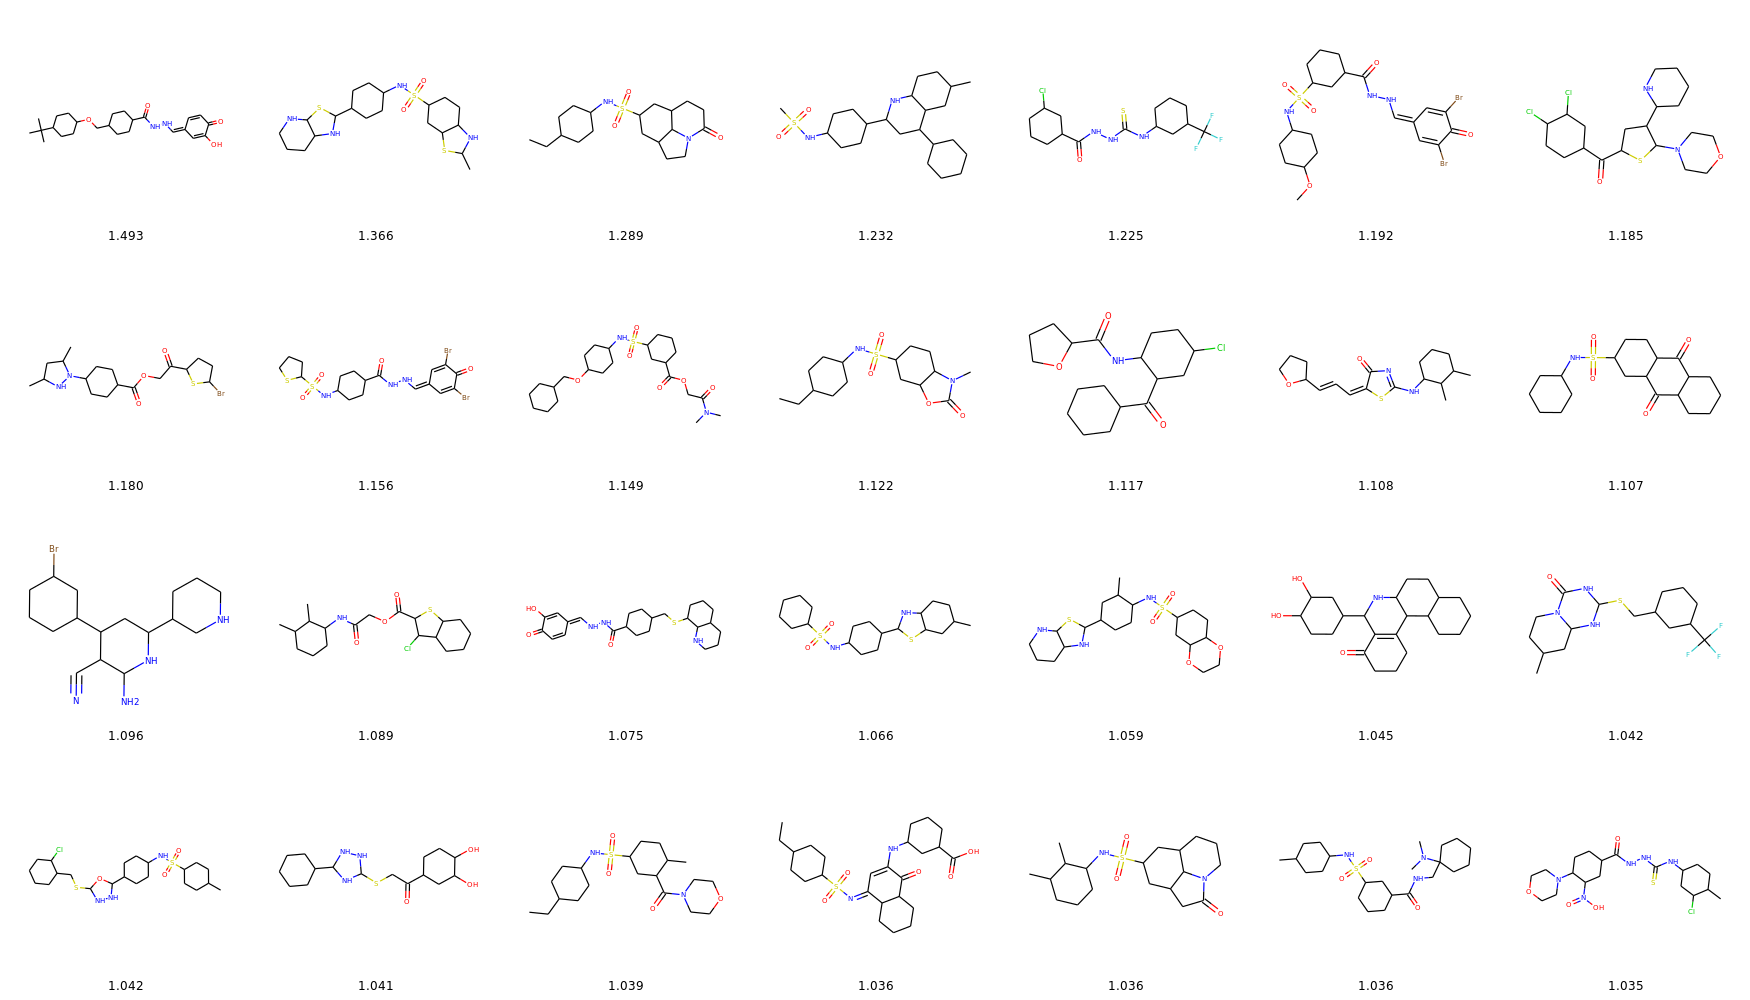




Exp: 588350
________________________________________________________________________________
CV   AUC ROC: 0.725 (+/- 0.055) [0.670:0.780]
Test AUC ROC: 0.753
--------------------------------------------------------------------------------
Using 59 selected constructs for 208 features
Train CV AUC ROC: 0.761 +- 0.071 [0.689:0.832]
Test     AUC ROC: 0.692
Ideal graphs: 59


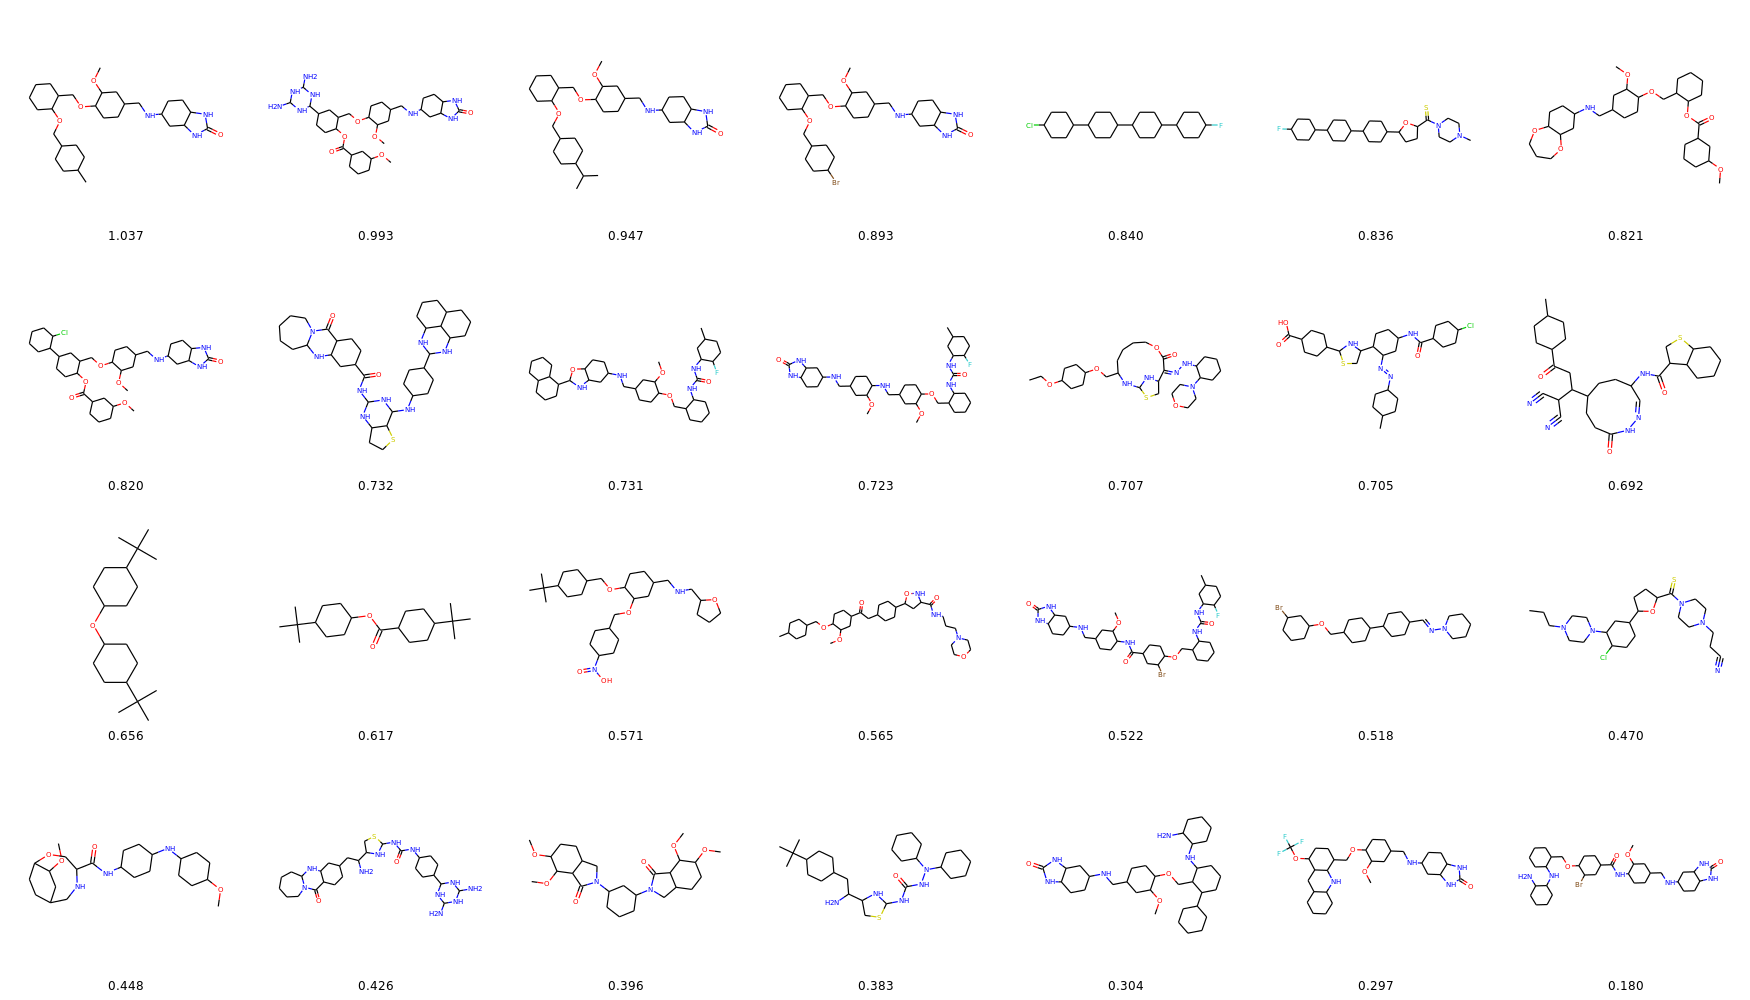

Top k graphs: 311


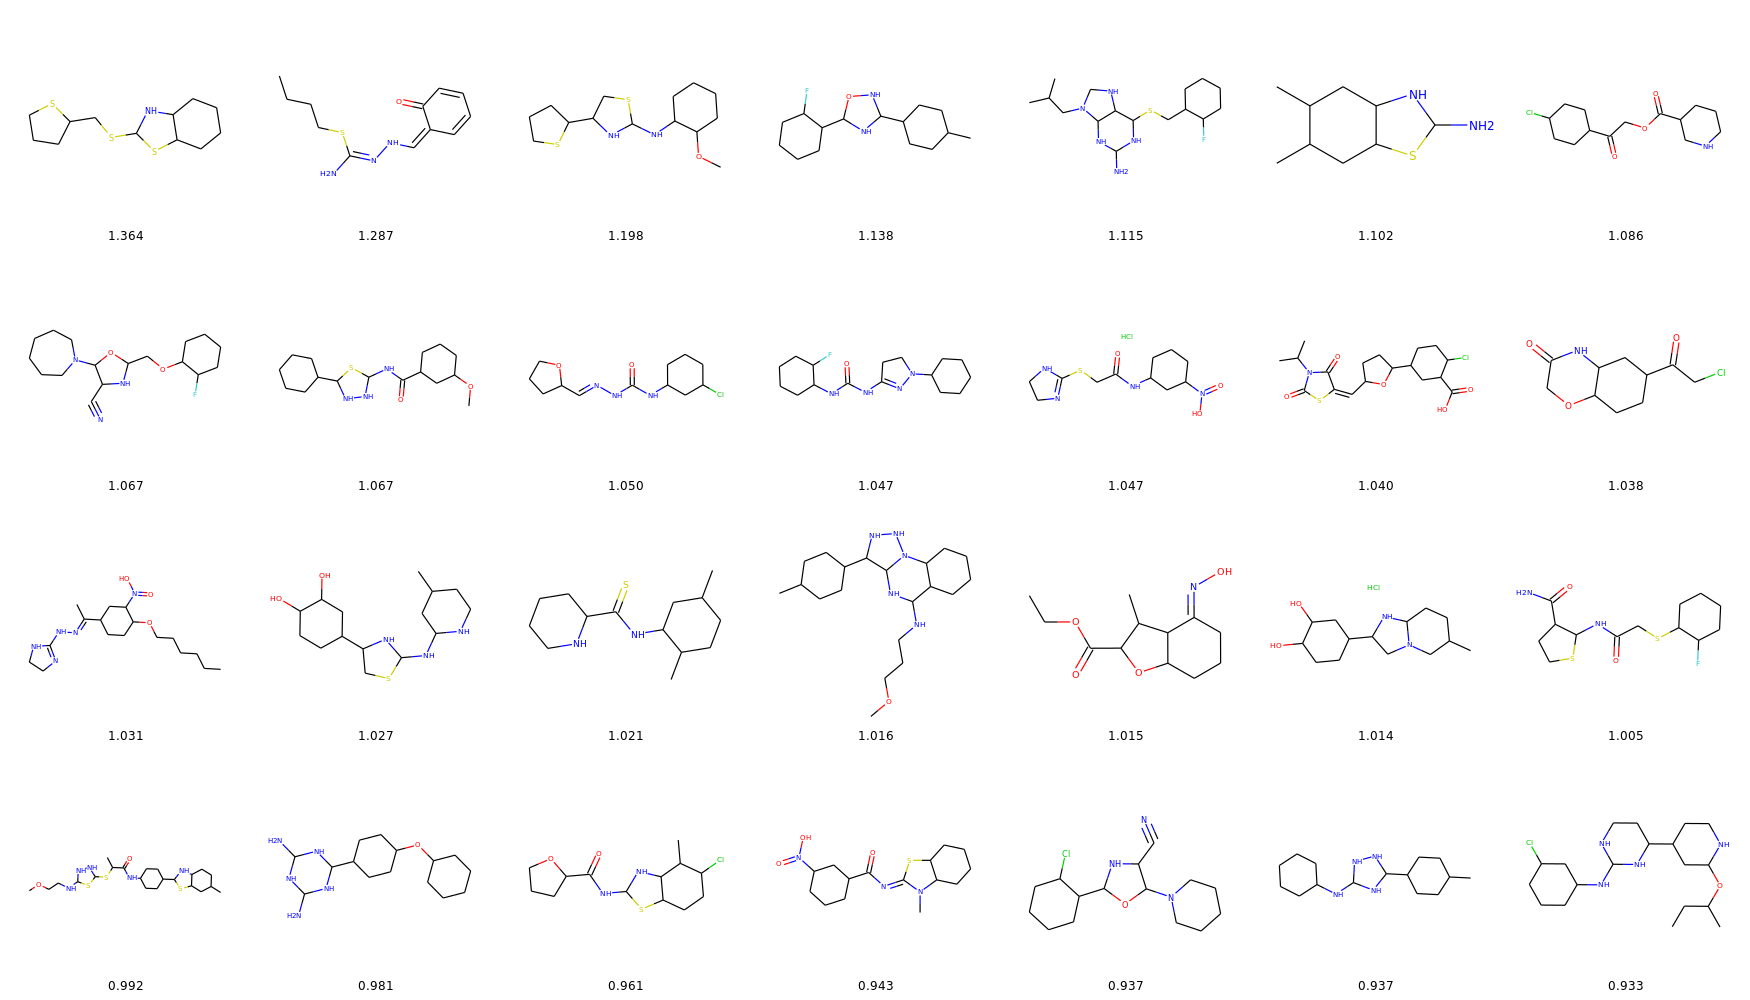




Exp: 651610
________________________________________________________________________________
CV   AUC ROC: 0.978 (+/- 0.009) [0.969:0.987]
Test AUC ROC: 0.948
--------------------------------------------------------------------------------
Using 64 selected constructs for 200 features
Train CV AUC ROC: 0.947 +- 0.007 [0.940:0.954]
Test     AUC ROC: 0.882
Ideal graphs: 64


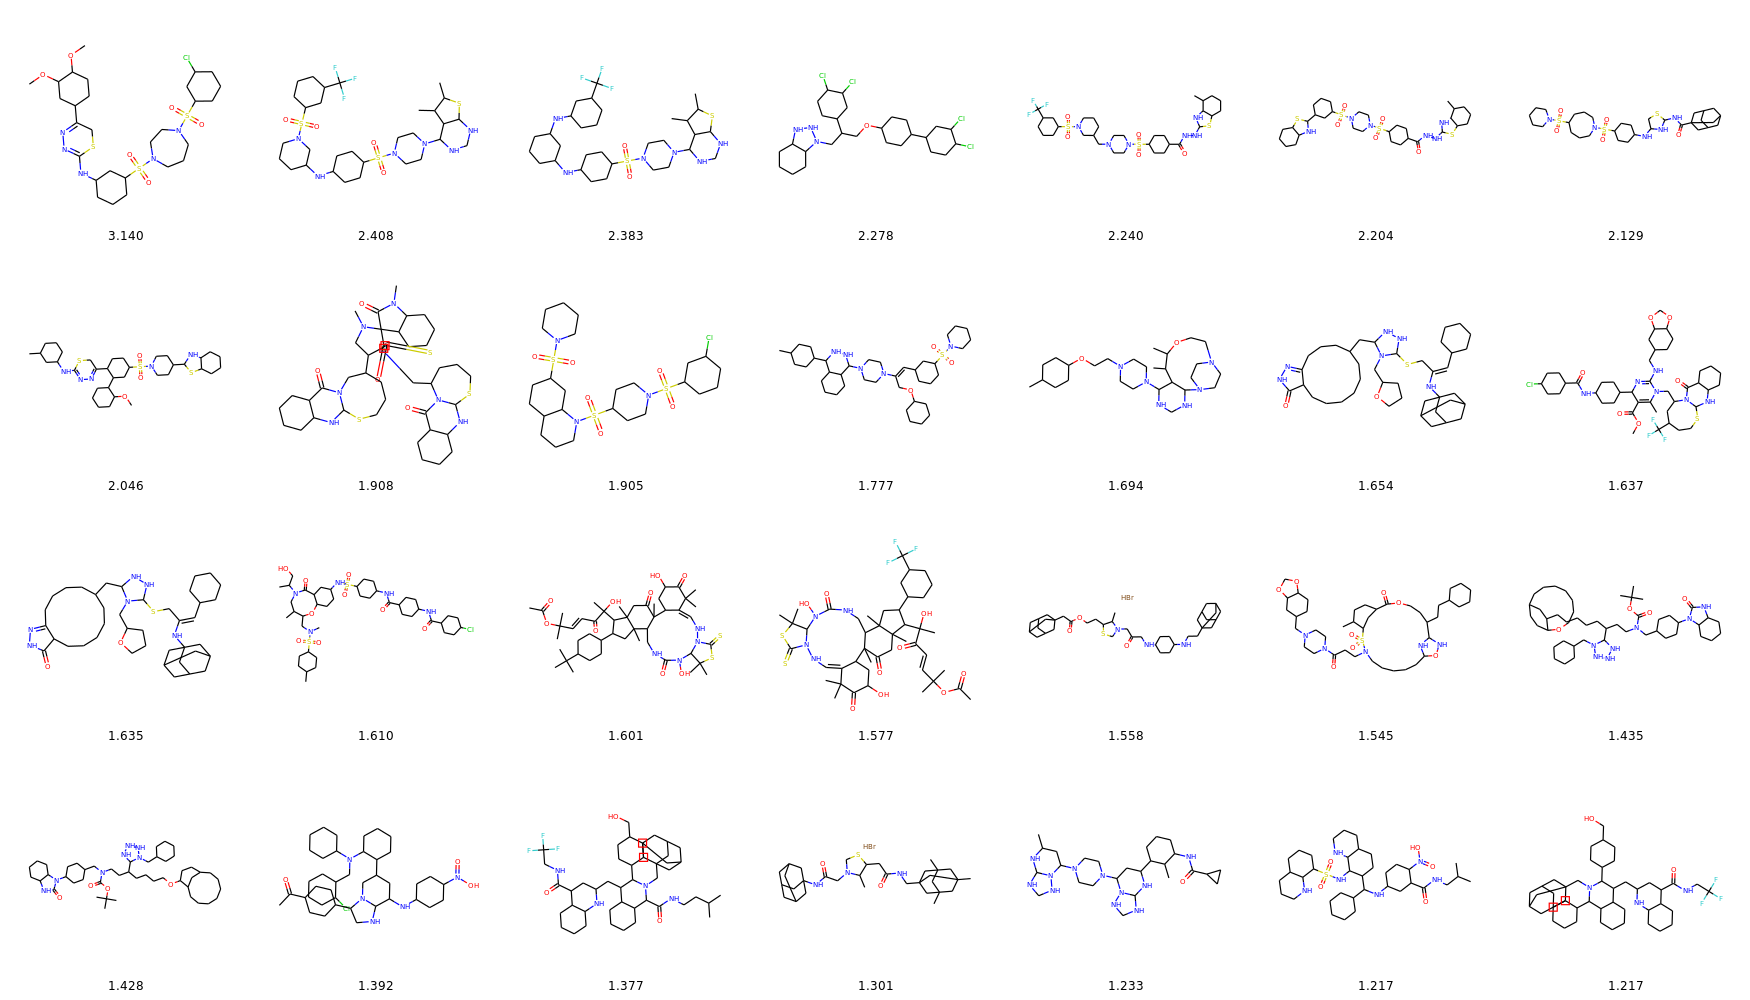

Top k graphs: 1000


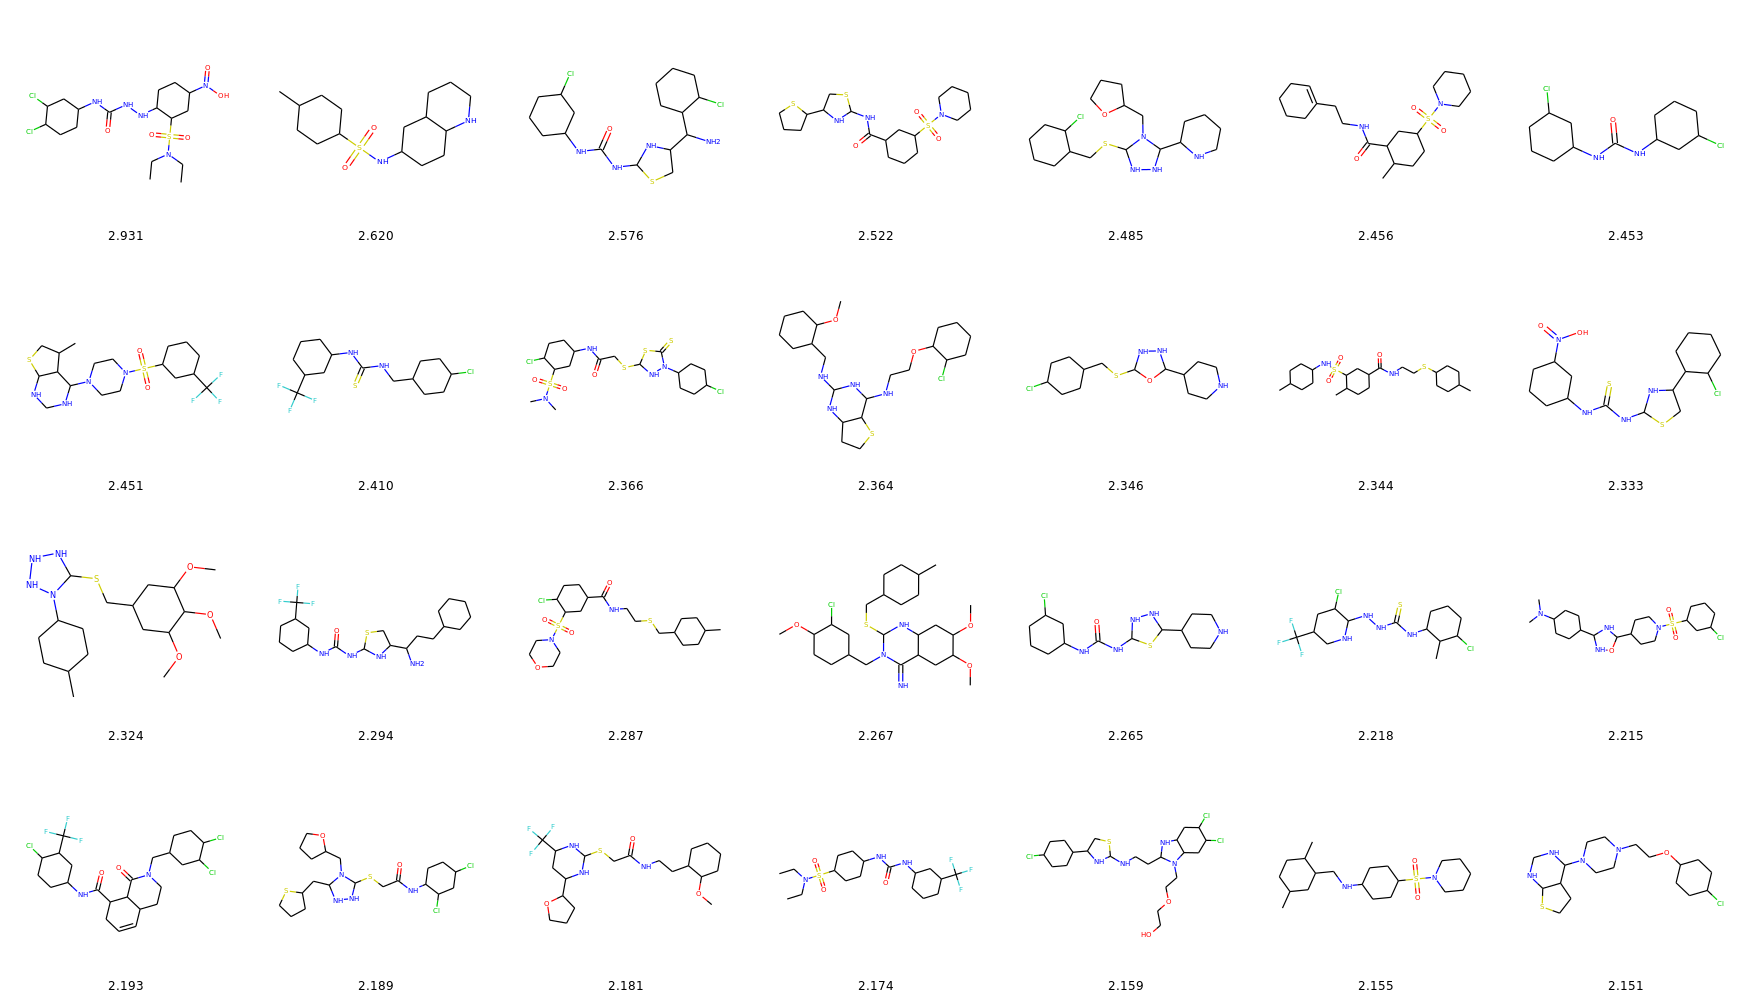




Exp: 624466
________________________________________________________________________________
CV   AUC ROC: 0.938 (+/- 0.011) [0.928:0.949]
Test AUC ROC: 0.928
--------------------------------------------------------------------------------
Using 199 selected constructs for 1500 features
Train CV AUC ROC: 0.791 +- 0.013 [0.778:0.805]
Test     AUC ROC: 0.771
Ideal graphs: 199


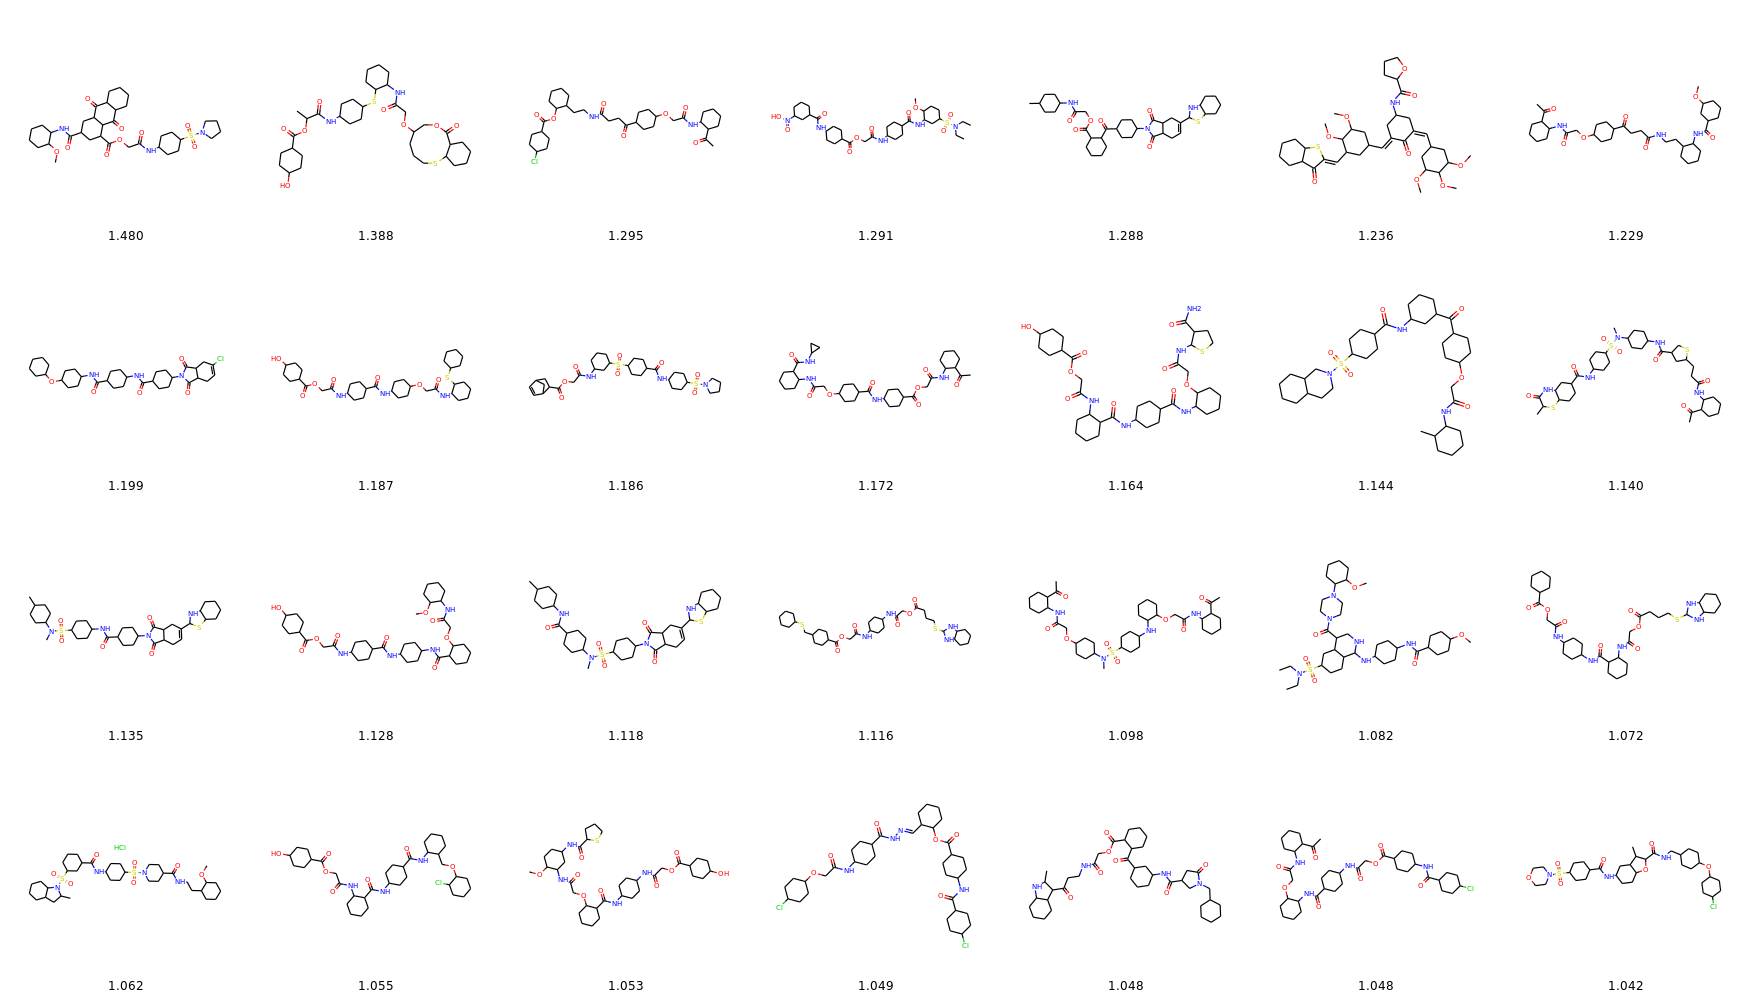

Top k graphs: 1000


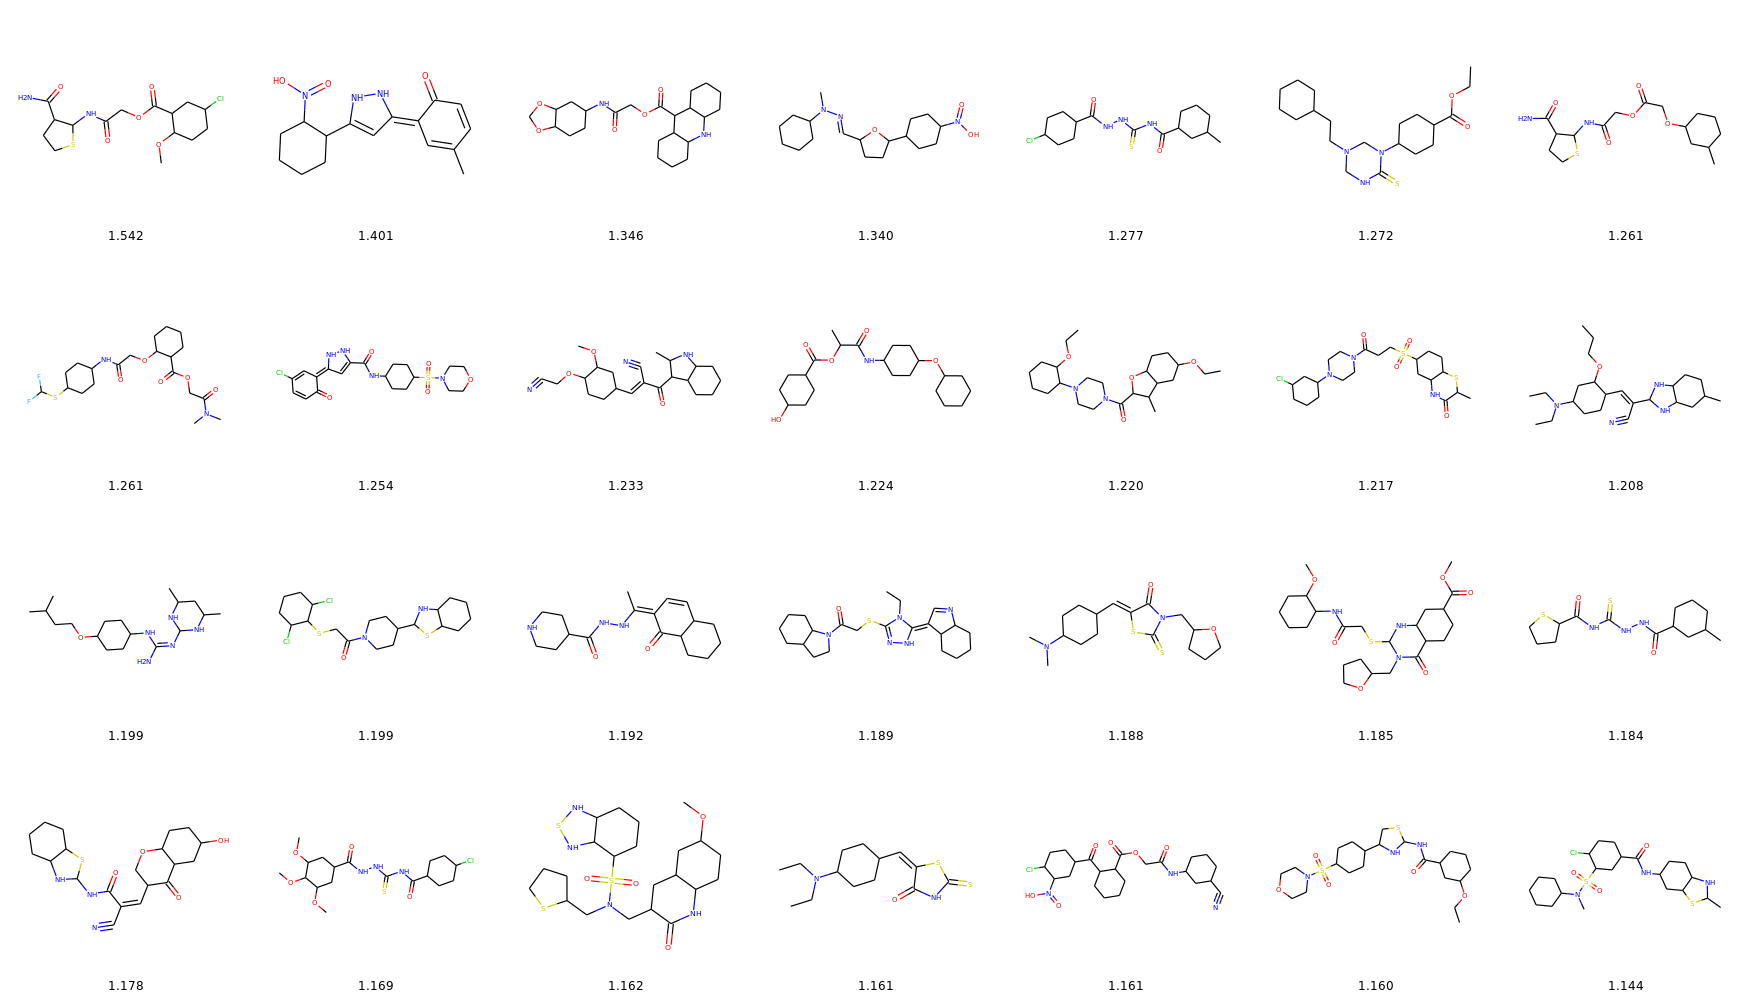




Exp: 492952
________________________________________________________________________________
CV   AUC ROC: 0.697 (+/- 0.076) [0.621:0.772]
Test AUC ROC: 0.737
--------------------------------------------------------------------------------
Using 182 selected constructs for 1174 features
Train CV AUC ROC: 0.702 +- 0.079 [0.623:0.780]
Test     AUC ROC: 0.638
Ideal graphs: 182


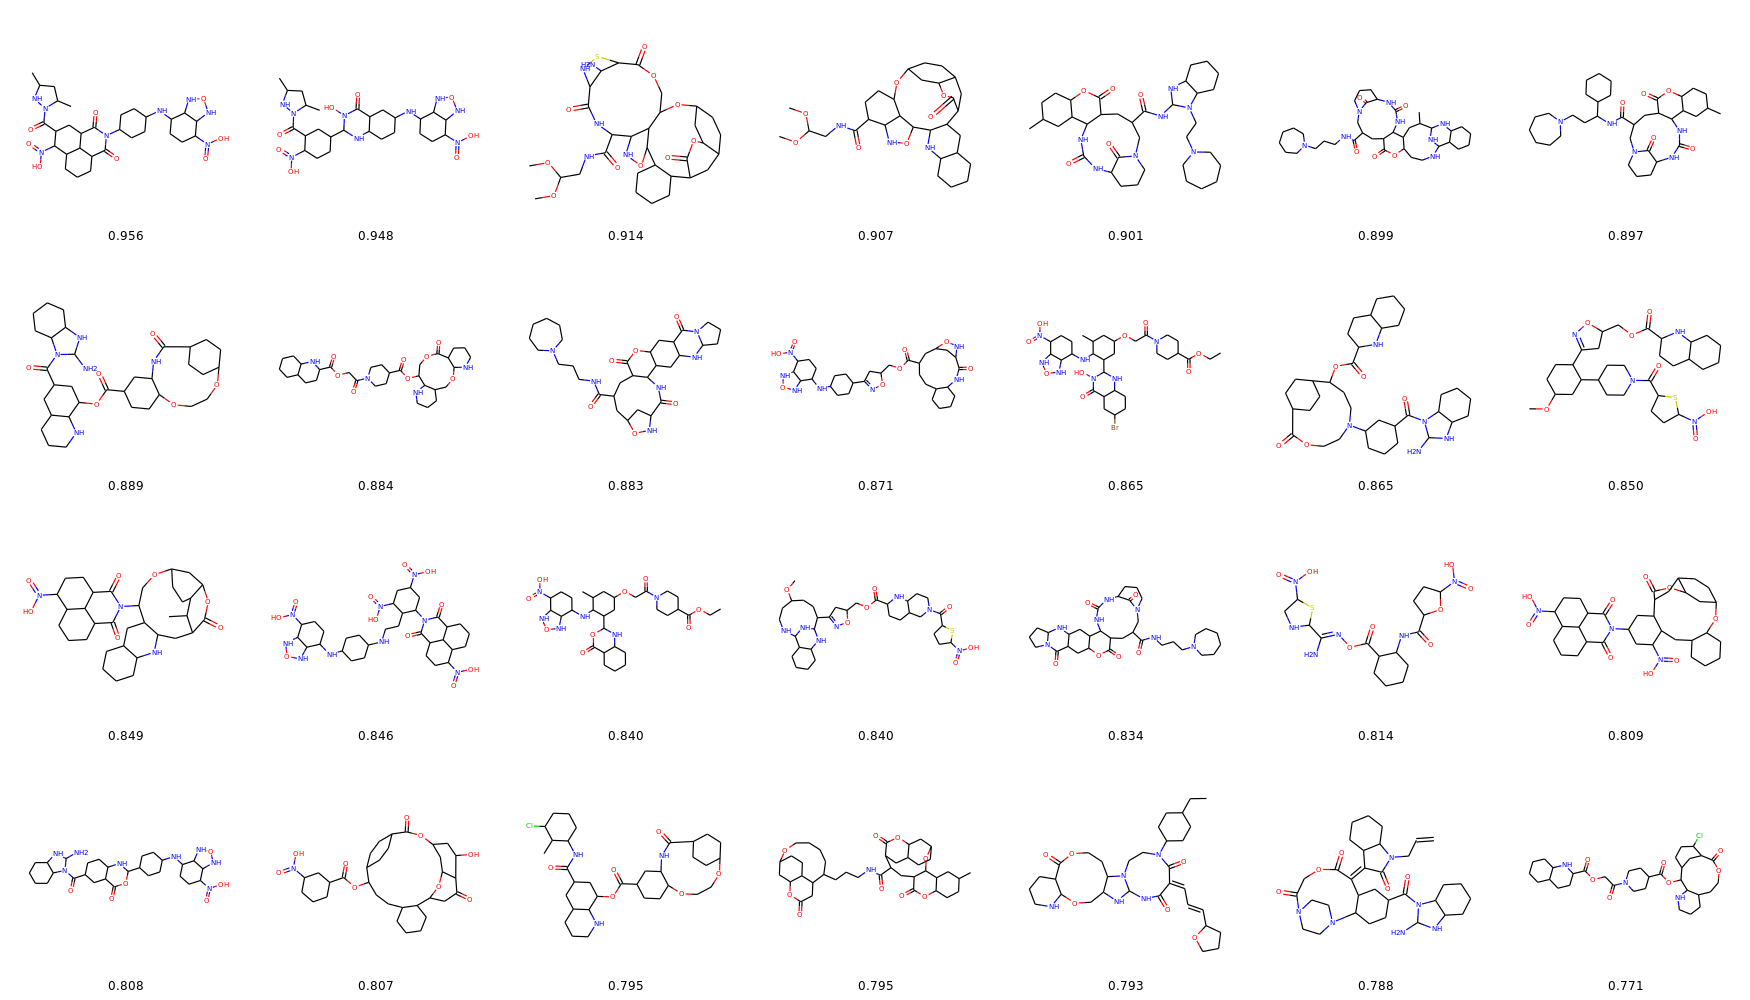

Top k graphs: 401


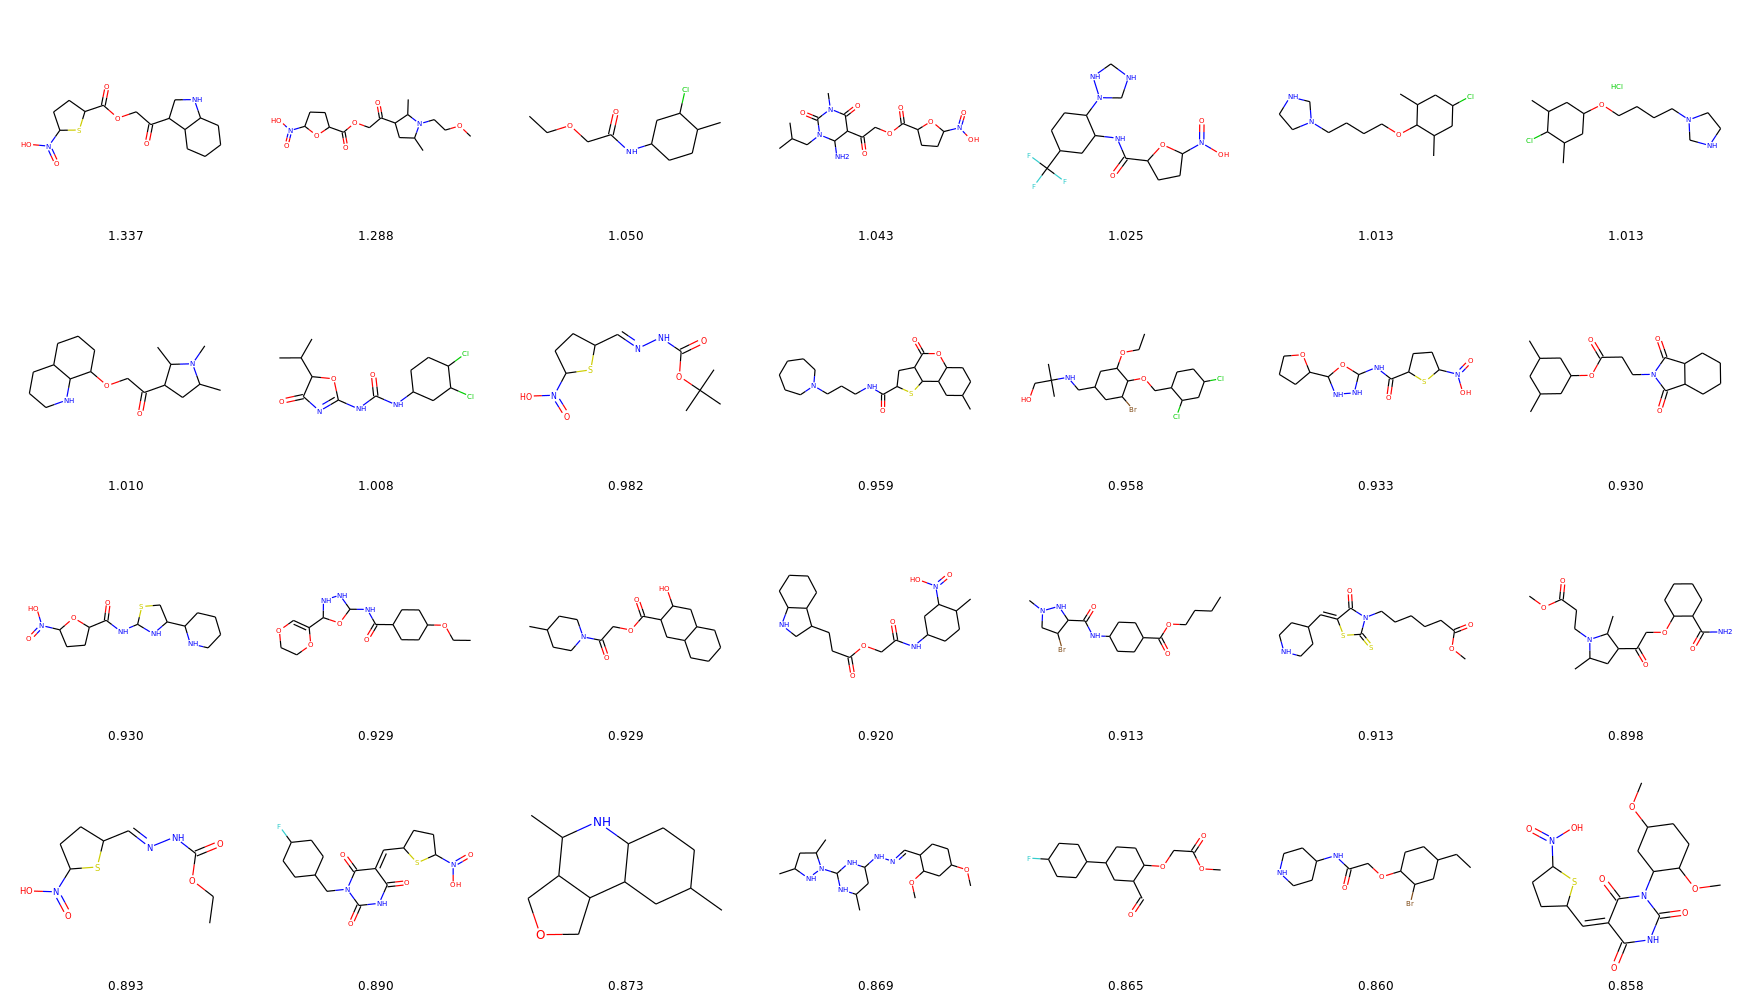




Exp: 463213
________________________________________________________________________________
CV   AUC ROC: 0.564 (+/- 0.069) [0.496:0.633]
Test AUC ROC: 0.663
--------------------------------------------------------------------------------
Using 99 selected constructs for 336 features
Train CV AUC ROC: 0.637 +- 0.061 [0.576:0.698]
Test     AUC ROC: 0.616
Ideal graphs: 99


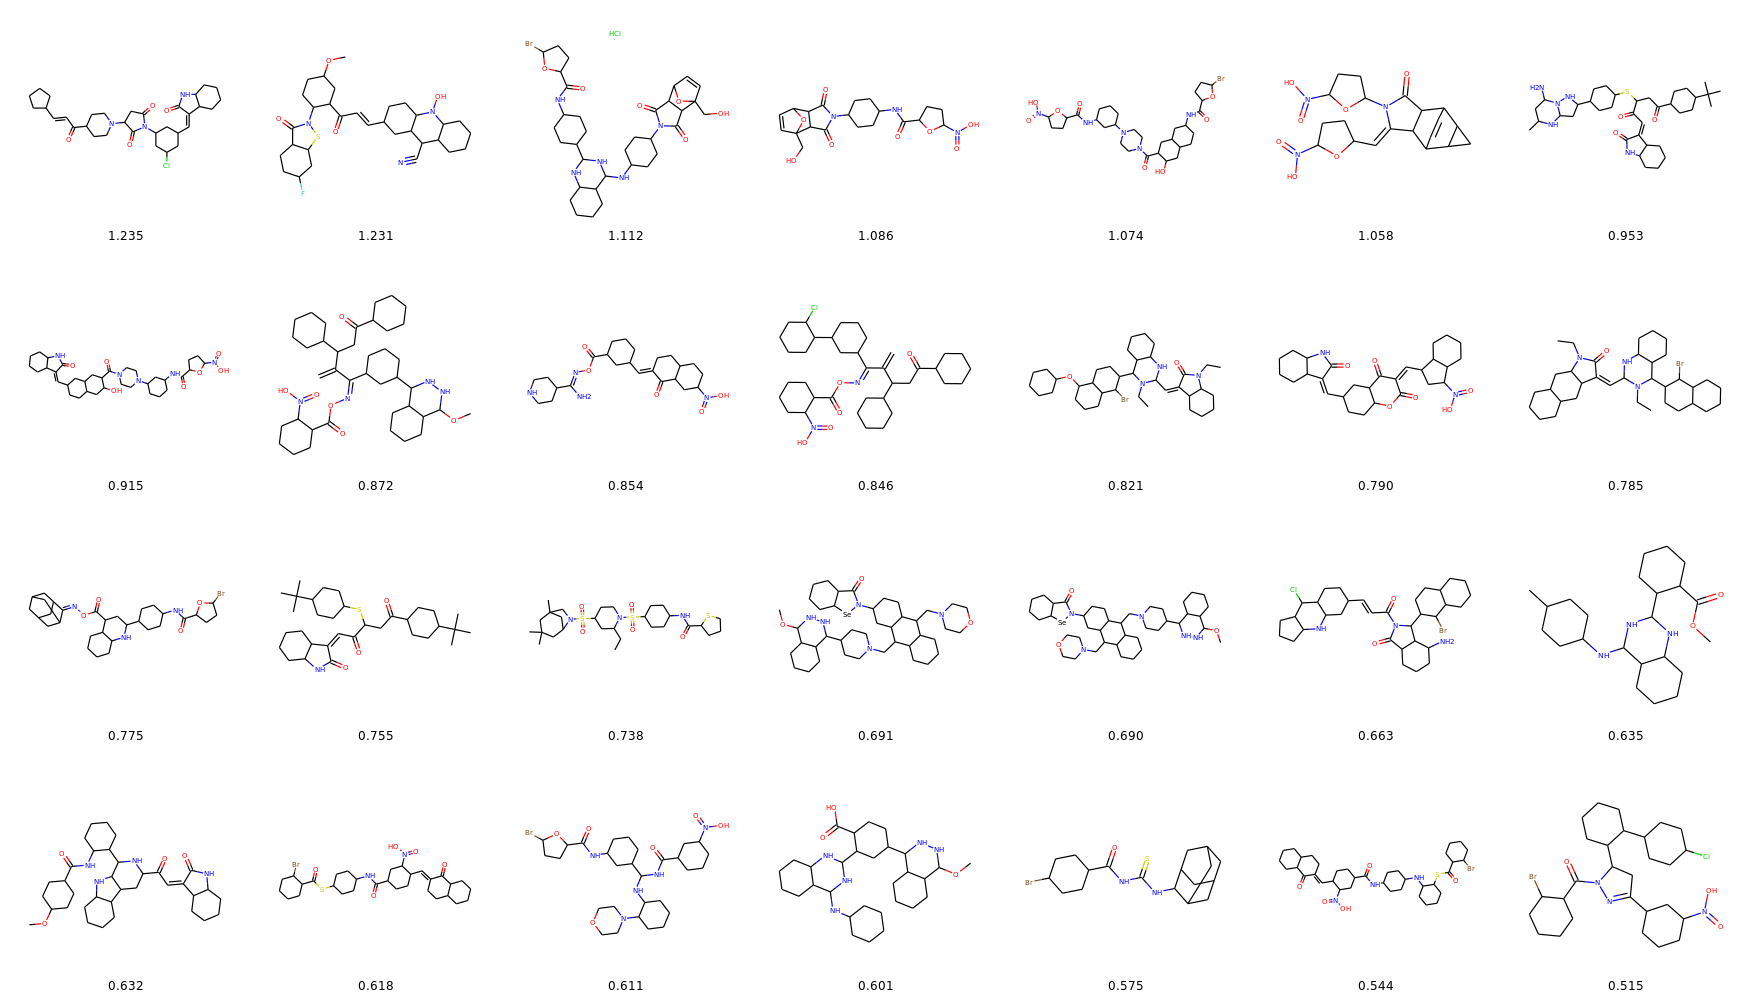

Top k graphs: 1000


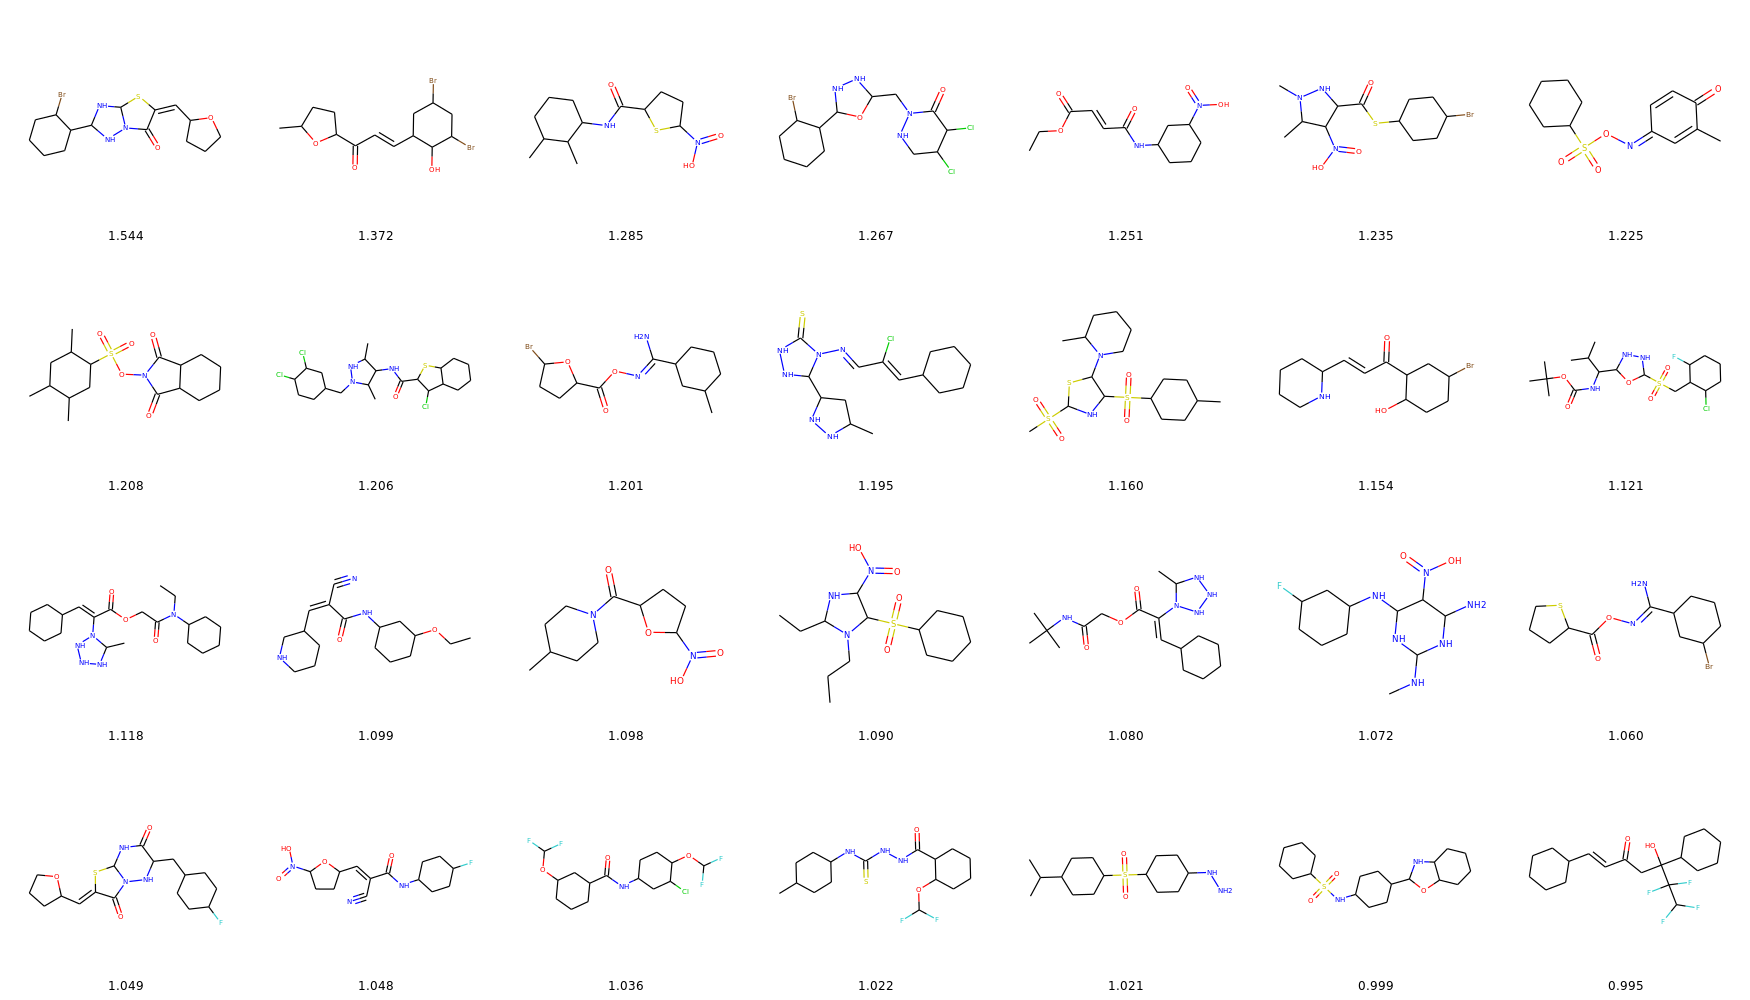

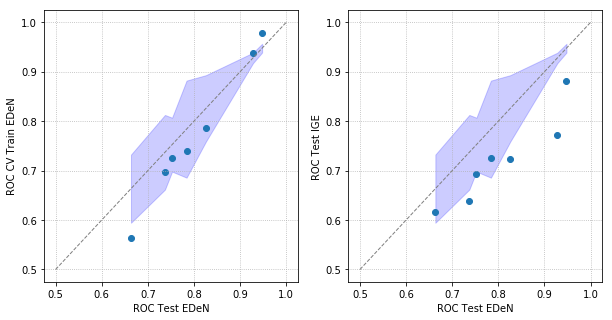

CPU times: user 2h 31min 2s, sys: 29min 16s, total: 3h 18s
Wall time: 5h 10min 30s


In [20]:
%%time
rocs_list = make_experiments(assay_ids, args)
plot(rocs_list, 'exp2')

---